In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import math
import pandas as pd
from scipy.optimize import curve_fit
import numpy.polynomial.polynomial as poly
import emcee
import corner
from scipy.optimize import minimize
from IPython.display import display, Math

#for reading ztf files
# from avro.datafile import DataFileReader, DataFileWriter
# from avro.io import DatumReader, DatumWriter
# import fastavro

In [2]:
#DETECTIONS
sn19rwd = pd.read_csv('./19rwd/detections.csv')
sn21gno = pd.read_csv('./21gno/detections.csv')
sn21heh = pd.read_csv('./21heh/detections.csv')
sn21vgn = pd.read_csv('./21vgn/detections.csv')
sn22hnt = pd.read_csv('./22hnt/detections.csv')
sn22jpx = pd.read_csv('./22jpx/detections.csv')

print(sn21vgn.columns)

#NON DETECTIONS 
sn19rwd_non = pd.read_csv('./19rwd/non_detections.csv')
sn21gno_non = pd.read_csv('./21gno/non_detections.csv')
sn21heh_non = pd.read_csv('./21heh/non_detections.csv')
sn21vgn_non = pd.read_csv('./21vgn/non_detections.csv')
sn22hnt_non = pd.read_csv('./22hnt/non_detections.csv')
sn22jpx_non = pd.read_csv('./22jpx/non_detections.csv')

print(sn21vgn_non.columns)

Index(['tid', 'mjd', 'candid', 'fid', 'pid', 'diffmaglim', 'isdiffpos', 'nid',
       'distnr', 'magpsf', 'magpsf_corr', 'magpsf_corr_ext', 'magap',
       'magap_corr', 'sigmapsf', 'sigmapsf_corr', 'sigmapsf_corr_ext',
       'sigmagap', 'sigmagap_corr', 'ra', 'dec', 'rb', 'rbversion', 'drb',
       'magapbig', 'sigmagapbig', 'rfid', 'has_stamp', 'corrected', 'dubious',
       'candid_alert', 'step_id_corr', 'phase', 'parent_candid'],
      dtype='object')
Index(['tid', 'mjd', 'fid', 'diffmaglim'], dtype='object')


In [3]:
#plotting routine
#goal: plot and find the LC points that are the decline of the 1st peak

def plot_LC(df, df_non, ID='SN ID',show=True):
    """
    input: df = DataFrame from detections.csv, ID = str of SN name
    output: individual plot of SN LC in g and r band
    """
    plt.figure(figsize=(7,5))
    plt.rcParams.update({'font.size': 15})
    
    #plot g band w/ err
    plt.scatter(df[df['fid']==1].mjd,df[df['fid']==1].magpsf, color='green', label='ztf g') #detections
    plt.errorbar(df[df['fid']==1].mjd,df[df['fid']==1].magpsf,df[df['fid']==1].sigmapsf, fmt='o',color='green', label='')
#     plt.scatter(np.array(df_non[df_non['fid']==1].mjd),np.array(df_non[df_non['fid']==1].diffmaglim), color='green', label='', marker='v', alpha=0.3)
    
    #plot r band w/ err
    plt.scatter(df[df['fid']==2].mjd,df[df['fid']==2].magpsf, color='red', label='ztf r') #detections
    plt.errorbar(df[df['fid']==2].mjd,df[df['fid']==2].magpsf,df[df['fid']==2].sigmapsf, fmt='o',color='red', label='')
#     plt.scatter(np.array(df_non[df_non['fid']==2].mjd),np.array(df_non[df_non['fid']==2].diffmaglim), color='red', label='', marker='v', alpha=0.3)

    plt.title(ID)
    plt.xlabel('MJD')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.gca().invert_yaxis()
    if show:
        plt.show()
    return

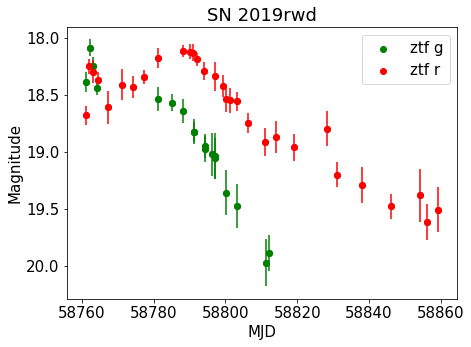

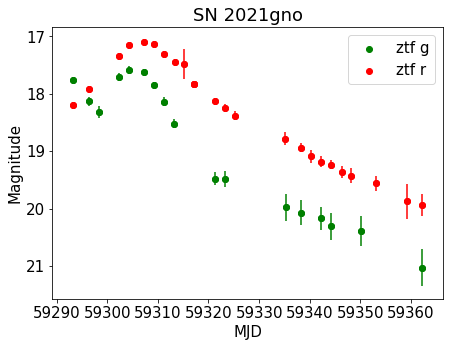

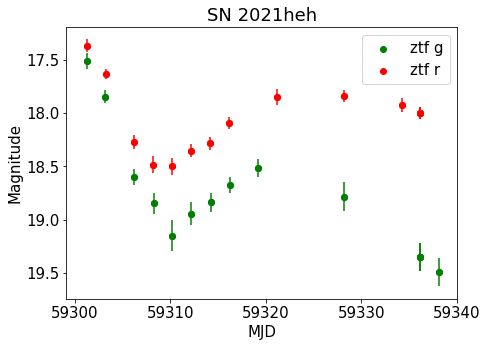

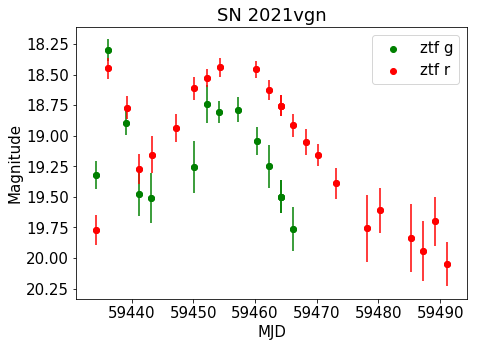

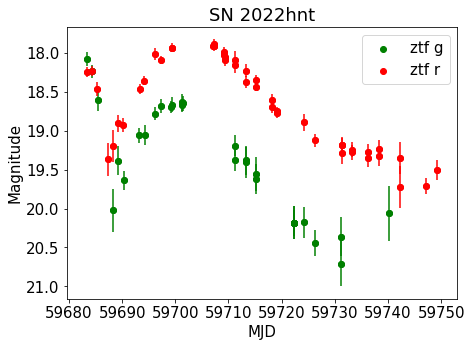

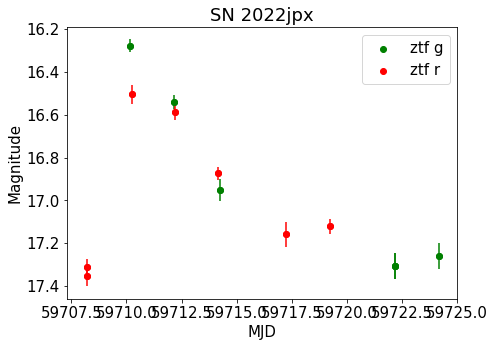

In [4]:
sn_df_list = [sn19rwd, sn21gno, sn21heh, sn21vgn, sn22hnt, sn22jpx]
sn_df_non_list = [sn19rwd_non, sn21gno_non, sn21heh_non, sn21vgn_non, sn22hnt_non, sn22jpx_non]
sn_ids = ['SN 2019rwd','SN 2021gno','SN 2021heh','SN 2021vgn','SN 2022hnt','SN 2022jpx']

for i,df in enumerate(sn_df_list):
    df_non = sn_df_non_list[i]
    plot_LC(df,df_non,ID=sn_ids[i])

In [5]:
#by eye selection of points in LC that make up first fall (indexing 0)

#sn19rwd: g:[1,2,3], r:[1,2,3,4]
#sn21gno: g:[0,1,2], r:[]
#sn21heh: g:[0,1,2,3,4], r:[0,1,2,3]
#sn21vgn: g:[1,2,3,4], r:[1,2,3]
#sn22hnt: g:[0,1,2,3], r:[0?,1,2,3]
#sn22jpx: g:[0,1,2,3], r:[2,3,4,5]

sn19rwd_gfall, sn19rwd_rfall = sn19rwd[sn19rwd['fid']==1][1:4], sn19rwd[sn19rwd['fid']==2][1:5]
sn21gno_gfall, sn21gno_rfall = sn21gno[sn21gno['fid']==1][0:3], _
sn21heh_gfall, sn21heh_rfall = sn21heh[sn21heh['fid']==1][0:5], sn21heh[sn21heh['fid']==2][0:4]
sn21vgn_gfall, sn21vgn_rfall = sn21vgn[sn21vgn['fid']==1][1:5], sn21vgn[sn21vgn['fid']==2][1:4]
sn22hnt_gfall, sn22hnt_rfall = sn22hnt[sn22hnt['fid']==1][0:4], sn22hnt[sn22hnt['fid']==2][0:4]
sn22jpx_gfall, sn22jpx_rfall = sn22jpx[sn22jpx['fid']==1][0:4], sn22jpx[sn22jpx['fid']==2][2:6]

In [6]:
# #defining fitting function
# def poly_fit(gfall, rfall, df, df_non, ID='ID', missing_rfall=False):
#     if missing_rfall:
#         gx, gy = np.array(gfall.mjd), np.array(gfall.magpsf)
#         gfit = poly.polyfit(gx,gy,3)
#         gxpl = np.linspace(gx[0],gx[-1])
        
#         plot_LC(df, df_non, ID=ID,show=False)
    
#         plt.plot(gxpl,poly.polyval(gxpl,gfit) , color='green',linestyle='--', lw=3,alpha=0.5)
#         plt.xlim(gx[0]-3,gx[-1]+3)
#         plt.ylim(gy[0]-.5,gy[-1]+.5)
#         plt.gca().invert_yaxis()
#         plt.show()
#         return gfit, _
#     else:
#         gx, gy = np.array(gfall.mjd), np.array(gfall.magpsf)
#         rx, ry = np.array(rfall.mjd), np.array(rfall.magpsf)
#         #fit y data and create list of x plotting points
#         gfit = poly.polyfit(gx,gy,3)
#         gxpl = np.linspace(gx[0],gx[-1])

#         rfit = poly.polyfit(rx,ry,3)
#         rxpl = np.linspace(rx[0],rx[-1])

#         plot_LC(df, df_non, ID=ID,show=False)

#         plt.plot(gxpl,poly.polyval(gxpl,gfit) , color='green',linestyle='--', lw=3,alpha=0.5)
#         plt.plot(rxpl,poly.polyval(rxpl,rfit) , color='red',linestyle='--', lw=3,alpha=0.5)
#         plt.xlim(min(gx[0],rx[0])-3,max(gx[-1],rx[-1])+3)
#         plt.ylim(min(gy[0],ry[0])-1.1,max(gy[-1],ry[-1])+0.75)
#         plt.gca().invert_yaxis()
#         plt.show()
#         return gfit, rfit

In [7]:
# sn19rwd_gfit, sn19rwd_rfit = poly_fit(sn19rwd_gfall, sn19rwd_rfall, sn19rwd, sn19rwd_non, 'SN 2019rwd')
# sn21gno_gfit, _            = poly_fit(sn21gno_gfall, sn21gno_rfall, sn21gno, sn21gno_non, 'SN 2021gno', missing_rfall=True)
# sn21heh_gfit, sn21heh_rfit = poly_fit(sn21heh_gfall, sn21heh_rfall, sn21heh, sn21heh_non, 'SN 2021heh')
# sn21vgn_gfit, sn21vgn_rfit = poly_fit(sn21vgn_gfall, sn21vgn_rfall, sn21vgn, sn21vgn_non, 'SN 2021vgn')
# sn22hnt_gfit, sn22hnt_rfit = poly_fit(sn22hnt_gfall, sn22hnt_rfall, sn22hnt, sn22hnt_non, 'SN 2022hnt')
# sn22jpx_gfit, sn22jpx_rfit = poly_fit(sn22jpx_gfall, sn22jpx_rfall, sn22jpx, sn22jpx_non, 'SN 2022jpx')

In [8]:
# #fitting rises + falls of 1st peak
# #objects w/ rises: sn19rwd, sn21vgn, sn22jpx

# sn19rwd_gall, sn19rwd_rall = sn19rwd[sn19rwd['fid']==1][0:4], sn19rwd[sn19rwd['fid']==2][0:5]
# sn21vgn_gall, sn21vgn_rall = sn21vgn[sn21vgn['fid']==1][0:5], sn21vgn[sn21vgn['fid']==2][0:4]
# sn22jpx_gall, sn22jpx_rall = sn22jpx[sn22jpx['fid']==1][0:4], sn22jpx[sn22jpx['fid']==2][0:7]

In [9]:
# sn19rwd_gfit_1, sn19rwd_rfit_1 = poly_fit(sn19rwd_gall, sn19rwd_rall, sn19rwd, sn19rwd_non, 'SN 2019rwd')
# sn21vgn_gfit_1, sn21vgn_rfit_1 = poly_fit(sn21vgn_gall, sn21vgn_rall, sn21vgn, sn21vgn_non, 'SN 2021vgn')
# sn22jpx_gfit_1, sn22jpx_rfit_1 = poly_fit(sn22jpx_gall, sn22jpx_rall, sn22jpx, sn22jpx_non, 'SN 2022jpx')

In [10]:
# LIGHTNING BOLT FITTING:
# FIRST RISE, FIRST FALL, SECOND RISE

In [11]:
#let's normalize (and whiten) the lightcurves
#peak magnitude = 1
#max of first peak => t=0

def norm_LC(df, gfall, rfall, missing_rfall=False):
    """
    input: 
        df = SN df from read in
        gfall = df containing 1st falling points in g band
        rfall = df containing 1st falling points in r band
        missing_rfall=False, only True for 2021gno 
    output:
        norm_sn_g, norm_sn_r = [time_g_band, mag_g_band], [time_r_band, mag_r_band]
        ^^ 2, 2D arrays containing normalized time and magnitude (normed to first peak, [t0, m0])
    """
    if missing_rfall:
        #g band normalization
        p_g = [np.array(gfall.mjd)[0], np.array(gfall.magpsf)[0]] #1st peak in g band: [time, mag]
        norm_t_g = (df[df['fid']==1].mjd - p_g[0])+3                 #normalized time in g band
        norm_m_g = df[df['fid']==1].magpsf - p_g[1]               #normalized mag in g band
        norm_sn_g = [norm_t_g, norm_m_g]
        if len(norm_t_g) != len(norm_m_g):
            print('ERR: uneven time and mag arrays [g band]')
        else:
            return norm_sn_g, _
    else:
        #g band normalization
        p_g = [np.array(gfall.mjd)[0], np.array(gfall.magpsf)[0]] #1st peak in g band: [time, mag]
        norm_t_g = (df[df['fid']==1].mjd - p_g[0])+3                 #normalized time in g band
        norm_m_g = (df[df['fid']==1].magpsf - p_g[1])              #normalized mag in g band
        norm_sn_g = [norm_t_g, norm_m_g]
        
        #r band normalization
        p_r = [np.array(rfall.mjd)[0], np.array(rfall.magpsf)[0]] #1st peak in g band: [time, mag]
        norm_t_r = (df[df['fid']==2].mjd - p_r[0])+3                 #normalized time in g band
        norm_m_r = (df[df['fid']==2].magpsf - p_r[1])              #normalized mag in g band
        norm_sn_r = [norm_t_r, norm_m_r]
        
        if len(norm_t_g) != len(norm_m_g):
            print('ERR: uneven time and mag arrays [g band]')
        elif len(norm_t_r) != len(norm_m_r):
            print('ERR: uneven time and mag arrays [r band]')
        else:
            return norm_sn_g, norm_sn_r

In [12]:
norm_sn19rwd_g, norm_sn19rwd_r = norm_LC(sn19rwd, sn19rwd_gfall, sn19rwd_rfall)
norm_sn21gno_g, norm_sn21gno_r = norm_LC(sn21gno, sn21gno_gfall, sn21gno_rfall, missing_rfall=True)
norm_sn21heh_g, norm_sn21heh_r = norm_LC(sn21heh, sn21heh_gfall, sn21heh_rfall)
norm_sn21vgn_g, norm_sn21vgn_r = norm_LC(sn21vgn, sn21vgn_gfall, sn21vgn_rfall)
norm_sn22hnt_g, norm_sn22hnt_r = norm_LC(sn22hnt, sn22hnt_gfall, sn22hnt_rfall)
norm_sn22jpx_g, norm_sn22jpx_r = norm_LC(sn22jpx, sn22jpx_gfall, sn22jpx_rfall)

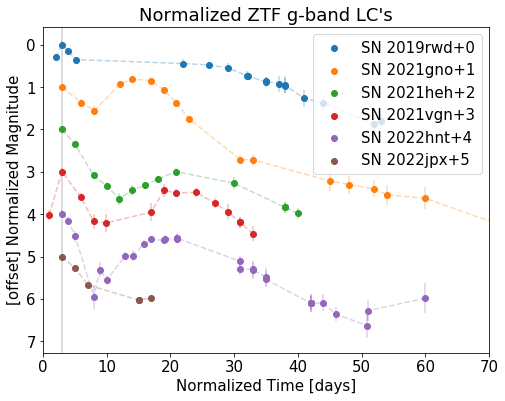

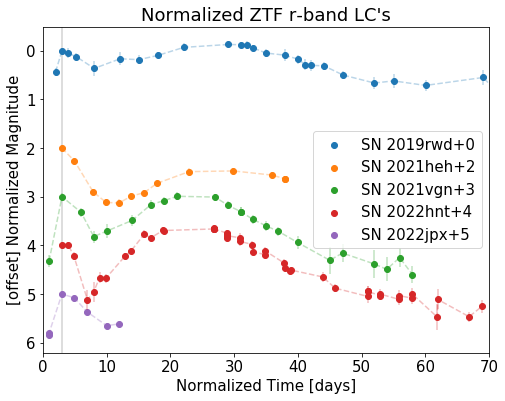

In [13]:
norm_g_all = [norm_sn19rwd_g,norm_sn21gno_g,norm_sn21heh_g,norm_sn21vgn_g,norm_sn22hnt_g,norm_sn22jpx_g]
norm_r_all = [norm_sn19rwd_r,norm_sn21gno_r,norm_sn21heh_r,norm_sn21vgn_r,norm_sn22hnt_r,norm_sn22jpx_r]
offsets = [0,1,2,3,4,5]

#making plot of g band
plt.figure(figsize=(8,6))
for i,sn in enumerate(norm_g_all):
    plt.scatter(sn[0], sn[1]+offsets[i], label=sn_ids[i]+'+'+str(offsets[i])) # normalized points
    df = sn_df_list[i]
    plt.errorbar(sn[0], sn[1]+offsets[i],df[df['fid']==1].sigmapsf, linestyle='--', alpha=0.3, label='')
    
plt.axvline(3, linestyle='-', color='lightgray', zorder=0)
plt.title('Normalized ZTF g-band LC\'s')
plt.xlabel('Normalized Time [days]')
plt.ylabel('[offset] Normalized Magnitude')
plt.legend()
plt.xlim(0, 70)
# plt.ylim(-1.5, 2.5)
plt.gca().invert_yaxis()
plt.savefig('./figures/normalized_LCs_g_offset.png')


#mkaing plot of r band
plt.figure(figsize=(8,6))
for i,sn in enumerate(norm_r_all):
    if type(sn) != str:
        plt.scatter(sn[0], sn[1]+offsets[i], label=sn_ids[i]+'+'+str(offsets[i])) # normalized points
        df = sn_df_list[i]
        plt.errorbar(sn[0], sn[1]+offsets[i], df[df['fid']==2].sigmapsf, linestyle='--', alpha=0.3, label='')
    
plt.axvline(3, linestyle='-', color='lightgray', zorder=0)
plt.title('Normalized ZTF r-band LC\'s')
plt.xlabel('Normalized Time [days]')
plt.ylabel('[offset] Normalized Magnitude')
plt.legend()
plt.xlim(0, 70)
# plt.ylim(-1.5, 2.5)
plt.gca().invert_yaxis()
plt.savefig('./figures/normalized_LCs_r_offset.png')

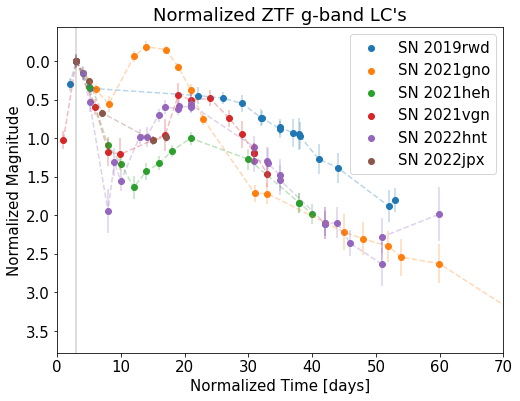

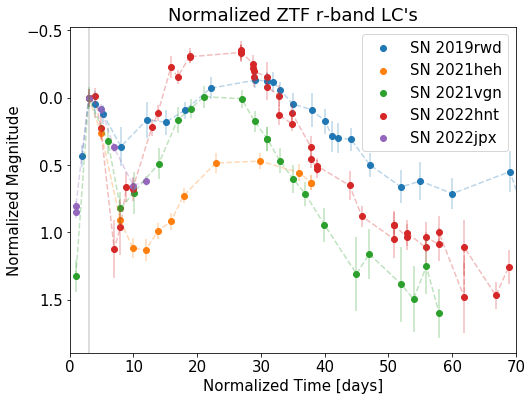

In [14]:
#making plot of g band
plt.figure(figsize=(8,6))
for i,sn in enumerate(norm_g_all):
    plt.scatter(sn[0], sn[1], label=sn_ids[i]) # normalized points
    df = sn_df_list[i]
    plt.errorbar(sn[0], sn[1], df[df['fid']==1].sigmapsf, linestyle='--', alpha=0.3, label='')
    
plt.axvline(3, linestyle='-', color='lightgray', zorder=0)
plt.title('Normalized ZTF g-band LC\'s')
plt.xlabel('Normalized Time [days]')
plt.ylabel('Normalized Magnitude')
plt.legend()
plt.xlim(0, 70)
# plt.ylim(-1.5, 2.5)
plt.gca().invert_yaxis()
plt.savefig('./figures/normalized_LCs_g.png')

#mkaing plot of r band
plt.figure(figsize=(8,6))
for i,sn in enumerate(norm_r_all):
    if type(sn) != str:
        plt.scatter(sn[0], sn[1], label=sn_ids[i]) # normalized points
        df = sn_df_list[i]
        plt.errorbar(sn[0], sn[1], df[df['fid']==2].sigmapsf, linestyle='--', alpha=0.3, label='')
    
plt.axvline(3, linestyle='-', color='lightgray', zorder=0)
plt.title('Normalized ZTF r-band LC\'s')
plt.xlabel('Normalized Time [days]')
plt.ylabel('Normalized Magnitude')
plt.legend()
plt.xlim(0, 70)
# plt.ylim(-1.5, 2.5)
plt.gca().invert_yaxis()
plt.savefig('./figures/normalized_LCs_r.png')

In [15]:
#manual selection of first rise, first fall, second rise

#FIRST RISE
#sn19rwd: g:[0,1], r:[0,1]
#sn21gno: N/A, N/A
#sn21heh: N/A, N/A
#sn21vgn: g:[0,1], r:[0,1]
#sn22hnt: N/A, N/A
#sn22jpx: N/A, r:[0,2]

#FIRST FALL
#sn19rwd: g:[1,2,3], r:[1,2,3,4]
#sn21gno: g:[0,1,2], r:N/A
#sn21heh: g:[0,1,2,3,4], r:[0,1,2,3]
#sn21vgn: g:[1,2,3,4], r:[1,2,3]
#sn22hnt: g:[0,1,2,3], r:[0,1,2,3]
#sn22jpx: g:[0,1,2,3], r:[2,3,4,5]

#SECOND RISE (limited by first rise time in days) (if no first rise, then 2 points)
#sn19rwd: g:[3,4], r:[4,5]
#sn21gno: g:[2,3], r:[0,1]
#sn21heh: g:[4,5], r:[3,4]
#sn21vgn: g:[4,5], r:[3,4]
#sn22hnt: g:[3,4], r:[3,4]
#sn22jpx: g:[3,4], r:[5,6]

In [16]:
#defining lines/liklihoods to be called in MCMC fitting
def model(theta):
    m, b, log_f = theta
    model = m*x + b
    return model

def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior_rise(theta): #for first/second rise
    m, b, log_f = theta
    if -5.0 < m < 0.0 and 0.0 < b < 10.0 and -10.0 < log_f < 5.0:
        return 0.0
    return -np.inf

def log_prior_fall(theta): #for first fall
    m, b, log_f = theta
    if 0.0 < m < 5.0 and -10.0 < b < 0.0 and -10.0 < log_f < 5.0:
        return 0.0
    return -np.inf

def log_probability_rise(theta, x, y, yerr):
    lp = log_prior_rise(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

def log_probability_fall(theta, x, y, yerr):
    lp = log_prior_fall(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [17]:
# x = norm_sn19rwd_g[0][0:2]
# y = norm_sn19rwd_g[1][0:2]
# yerr = np.array(sn19rwd[sn19rwd['fid']==1].sigmapsf)[0:2]

# #"minimizing" the log_liklihood function to find better initial guesses for MCMC fitting
# np.random.seed(42)
# nll = lambda *args: -log_likelihood(*args)
# initial = np.array([0.25, 2.0, np.log(0.5)]) + 0.1 * np.random.randn(3)
# soln = minimize(nll, initial, args=(x, y, yerr))
# m_ml, b_ml, log_f_ml = soln.x

# #setting MCMC search params
# pos = soln.x + 1e-4 * np.random.randn(32, 3)
# nwalkers, ndim = pos.shape

# #actually doing MCMC
# sampler = emcee.EnsembleSampler(
#     nwalkers, ndim, log_probability_rise, args=(x, y, yerr)
# )
# sampler.run_mcmc(pos, 5000, progress=True);

In [18]:
# flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

# mcmc_results =[]
# #retrieve the 16th/50th/84th percentile for m,b,log_f and the lower/upper bounds on each
# for i in range(ndim):
#     mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
#     q = np.diff(mcmc)
#     arr = [mcmc[1], q[0], q[1]]
#     mcmc_results.append(arr)
# #     txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
# #     txt = txt.format(mcmc[1], q[0], q[1], labels[i])
# #     display(Math(txt))
# print(np.shape(mcmc_results))

# #draw best fit line on plot
# new_theta_max  = sampler.flatchain[np.argmax(sampler.flatlnprobability)]
# new_best_fit_model = model(new_theta_max)
# # plt.plot(x,new_best_fit_model,label='Highest Likelihood Model')

In [19]:
# input: x, y, yerr, [m0,b0,logf0], rise/fall, 
# output: [[m,ml,mu],[b,bl,bu],[logf,logfl,logfu]], best_fit_model[N,2]

def mcmc_fit(x, y, yerr, p0=[1,0,1], rise=True):
    #"minimizing" the log_liklihood function to find better initial guesses for MCMC fitting
    np.random.seed(42)
    nll = lambda *args: -log_likelihood(*args)
    initial = np.array([p0[0], p0[1], np.log(p0[2])]) + 0.1 * np.random.randn(3)
    soln = minimize(nll, initial, args=(x, y, yerr))
    m_ml, b_ml, _ = soln.x
    log_f_ml=-2
    new_soln = np.array([m_ml, b_ml, log_f_ml])
    
    #setting MCMC search params
    pos = new_soln + 1e-4 * np.random.randn(32, 3)
    nwalkers, ndim = pos.shape

    #actually doing MCMC
    if rise:
        sampler = emcee.EnsembleSampler(
            nwalkers, ndim, log_probability_rise, args=(x, y, yerr)
        )
        sampler.run_mcmc(pos, 2000, progress=True);
    if not rise:
        sampler = emcee.EnsembleSampler(
            nwalkers, ndim, log_probability_fall, args=(x, y, yerr)
        )
        sampler.run_mcmc(pos, 2000, progress=True);
    
    flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

    mcmc_results =[]
    #retrieve the 16th/50th/84th percentile for m,b,log_f and the lower/upper bounds on each
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        arr = [mcmc[1], q[0], q[1]]
        mcmc_results.append(arr)
        
#     #draw best fit line on plot
#     best_theta_max  = sampler.flatchain[np.argmax(sampler.flatlnprobability)]
#     best_fit_model = model(best_theta_max)
    
    return mcmc_results, sampler

In [20]:
# INDIVIDUAL FITS

#first rise fits, g-band
mcmc_19rwd_g_r1,_ = mcmc_fit(norm_sn19rwd_g[0][0:2], norm_sn19rwd_g[1][0:2], np.array(sn19rwd[sn19rwd['fid']==1].sigmapsf)[0:2], [-0.25, 2.0, 0.5])
mcmc_21vgn_g_r1,test = mcmc_fit(norm_sn21vgn_g[0][0:2], norm_sn21vgn_g[1][0:2], np.array(sn21vgn[sn21vgn['fid']==1].sigmapsf)[0:2], [-0.25, 2.0, 0.5])
#first rise fits, r-band
mcmc_19rwd_r_r1,_ = mcmc_fit(norm_sn19rwd_r[0][0:2], norm_sn19rwd_r[1][0:2], np.array(sn19rwd[sn19rwd['fid']==2].sigmapsf)[0:2], [-0.25, 2.0, 0.5])
mcmc_21vgn_r_r1,_ = mcmc_fit(norm_sn21vgn_r[0][0:2], norm_sn21vgn_r[1][0:2], np.array(sn21vgn[sn21vgn['fid']==2].sigmapsf)[0:2], [-0.25, 2.0, 0.5])
mcmc_22jpx_r_r1,_ = mcmc_fit(norm_sn22jpx_r[0][0:3], norm_sn22jpx_r[1][0:3], np.array(sn22jpx[sn22jpx['fid']==2].sigmapsf)[0:3], [-0.25, 2.0, 0.5])

 13%|█▎        | 269/2000 [00:31<04:32,  6.35it/s]Traceback (most recent call last):
  File "/home/aec3675/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-16-e1a6dba49690>", line 29, in log_probability_rise
    return lp + log_likelihood(theta, x, y, yerr)
  File "<ipython-input-16-e1a6dba49690>", line 10, in log_likelihood
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
  File "/home/aec3675/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py", line 1585, in wrapper
    index=left.index, name=res_name, dtype=None)
  File "/home/aec3675/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py", line 1474, in _construct_result
    out = left._constructor(result, index=index, dtype=dtype)
  File "/home/aec3675/anaconda3/lib/python3.7/site-packages/pandas/core/series.py", line 264, in __init__
    data = SingleBlockManager(data, index, fastpath=True)
  File "/home/aec3675/anacon

emcee: Exception while calling your likelihood function:
  params: [-0.37264149  1.12586381 -2.90046163]
  args: (1    2.000243
3    3.000000
Name: mjd, dtype: float64, 1    0.302159
3    0.000000
Name: magpsf, dtype: float64, array([0.08831305, 0.07456923]))
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [ ]:
# fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
# samples = sample_test.get_chain()
# labels = ["m", "b", "log(f)"]
# for i in range(3):
#     ax = axes[i]
#     ax.plot(samples[:, :, i], "k", alpha=0.3)
#     ax.set_xlim(0, len(samples))
#     ax.set_ylabel(labels[i])
#     ax.yaxis.set_label_coords(-0.1, 0.5)

# axes[-1].set_xlabel("step number");

In [ ]:
# flat_samples = sample_test.get_chain(discard=100, thin=15, flat=True)
# print(flat_samples.shape)

# fig = corner.corner(
#     flat_samples, labels=labels
# );

# print(mcmc_19rwd_g_r1)

In [ ]:
# INDIVIDUAL FITS

#first fall fits, g-band
mcmc_19rwd_g_f1,_ = mcmc_fit(norm_sn19rwd_g[0][1:4], norm_sn19rwd_g[1][1:4], np.array(sn19rwd[sn19rwd['fid']==1].sigmapsf)[1:4], [0.25, -2.0, 0.5], rise=False)
mcmc_21gno_g_f1,_ = mcmc_fit(norm_sn21gno_g[0][0:3], norm_sn21gno_g[1][0:3], np.array(sn21gno[sn21gno['fid']==1].sigmapsf)[0:3], [0.25, -2.0, 0.5], rise=False)
mcmc_21heh_g_f1,_ = mcmc_fit(norm_sn21heh_g[0][0:5], norm_sn21heh_g[1][0:5], np.array(sn21heh[sn21heh['fid']==1].sigmapsf)[0:5], [0.25, -2.0, 0.5], rise=False)
mcmc_21vgn_g_f1,_ = mcmc_fit(norm_sn21vgn_g[0][1:5], norm_sn21vgn_g[1][1:5], np.array(sn21vgn[sn21vgn['fid']==1].sigmapsf)[1:5], [0.25, -2.0, 0.5], rise=False)
mcmc_22hnt_g_f1,_ = mcmc_fit(norm_sn22hnt_g[0][0:4], norm_sn22hnt_g[1][0:4], np.array(sn22hnt[sn22hnt['fid']==1].sigmapsf)[0:4], [0.25, -2.0, 0.5], rise=False)
mcmc_22jpx_g_f1,_ = mcmc_fit(norm_sn22jpx_g[0][0:4], norm_sn22jpx_g[1][0:4], np.array(sn22jpx[sn22jpx['fid']==1].sigmapsf)[0:4], [0.25, -2.0, 0.5], rise=False)

#first fall fits, r-band
mcmc_19rwd_r_f1,_ = mcmc_fit(norm_sn19rwd_r[0][1:5], norm_sn19rwd_r[1][1:5], np.array(sn19rwd[sn19rwd['fid']==2].sigmapsf)[1:5], [0.25, -2.0, 0.5], rise=False)
#2021gno no r fall
mcmc_21heh_r_f1,_ = mcmc_fit(norm_sn21heh_r[0][0:4], norm_sn21heh_r[1][0:4], np.array(sn21heh[sn21heh['fid']==2].sigmapsf)[0:4], [0.25, -2.0, 0.5], rise=False)
mcmc_21vgn_r_f1,_ = mcmc_fit(norm_sn21vgn_r[0][1:4], norm_sn21vgn_r[1][1:4], np.array(sn21vgn[sn21vgn['fid']==2].sigmapsf)[1:4], [0.25, -2.0, 0.5], rise=False)
mcmc_22hnt_r_f1,_ = mcmc_fit(norm_sn22hnt_r[0][0:4], norm_sn22hnt_r[1][0:4], np.array(sn22hnt[sn22hnt['fid']==2].sigmapsf)[0:4], [0.25, -2.0, 0.5], rise=False)
mcmc_22jpx_r_f1,_ = mcmc_fit(norm_sn22jpx_r[0][2:6], norm_sn22jpx_r[1][2:6], np.array(sn22jpx[sn22jpx['fid']==2].sigmapsf)[2:6], [0.25, -2.0, 0.5], rise=False)

In [ ]:
# INDIVIDUAL FITS

#2nd rise fits, gband
mcmc_19rwd_g_r2,_ = mcmc_fit(norm_sn19rwd_g[0][3:5], norm_sn19rwd_g[1][3:5], np.array(sn19rwd[sn19rwd['fid']==1].sigmapsf)[3:5], [-0.25, 2.0, 0.5])
mcmc_21gno_g_r2,_ = mcmc_fit(norm_sn21gno_g[0][2:4], norm_sn21gno_g[1][2:4], np.array(sn21gno[sn21gno['fid']==1].sigmapsf)[2:4], [-0.25, 2.0, 0.5])
mcmc_21heh_g_r2,_ = mcmc_fit(norm_sn21heh_g[0][4:6], norm_sn21heh_g[1][4:6], np.array(sn21heh[sn21heh['fid']==1].sigmapsf)[4:6], [-0.25, 2.0, 0.5])
mcmc_21vgn_g_r2,_ = mcmc_fit(norm_sn21vgn_g[0][4:6], norm_sn21vgn_g[1][4:6], np.array(sn21vgn[sn21vgn['fid']==1].sigmapsf)[4:6], [-0.25, 2.0, 0.5])
mcmc_22hnt_g_r2,_ = mcmc_fit(norm_sn22hnt_g[0][3:5], norm_sn22hnt_g[1][3:5], np.array(sn22hnt[sn22hnt['fid']==1].sigmapsf)[3:5], [-0.25, 2.0, 0.5])
mcmc_22jpx_g_r2,_ = mcmc_fit(norm_sn22jpx_g[0][3:5], norm_sn22jpx_g[1][3:5], np.array(sn22jpx[sn22jpx['fid']==1].sigmapsf)[3:5], [-0.25, 2.0, 0.5])

#2nd rise fits, rband
mcmc_19rwd_r_r2,_ = mcmc_fit(norm_sn19rwd_r[0][4:6], norm_sn19rwd_r[1][4:6], np.array(sn19rwd[sn19rwd['fid']==2].sigmapsf)[4:6], [-0.25, 2.0, 0.5])
#ignoring 21gno b/c not normalized rn
mcmc_21heh_r_r2,_ = mcmc_fit(norm_sn21heh_r[0][3:5], norm_sn21heh_r[1][3:5], np.array(sn21heh[sn21heh['fid']==2].sigmapsf)[3:5], [-0.25, 2.0, 0.5])
mcmc_21vgn_r_r2,_ = mcmc_fit(norm_sn21vgn_r[0][3:5], norm_sn21vgn_r[1][3:5], np.array(sn21vgn[sn21vgn['fid']==2].sigmapsf)[3:5], [-0.25, 2.0, 0.5])
mcmc_22hnt_r_r2,_ = mcmc_fit(norm_sn22hnt_r[0][3:5], norm_sn22hnt_r[1][3:5], np.array(sn22hnt[sn22hnt['fid']==2].sigmapsf)[3:5], [-0.25, 2.0, 0.5])
mcmc_22jpx_r_r2,_ = mcmc_fit(norm_sn22jpx_r[0][5:8], norm_sn22jpx_r[1][5:8], np.array(sn22jpx[sn22jpx['fid']==2].sigmapsf)[5:8], [-0.25, 2.0, 0.5])

In [ ]:
def line(x,m,b):
    return m*x +b

colors=['blue', 'orange', 'green', 'red', 'purple', 'brown']

def plot_individ_mcmc(norm_sn, mcmc_r1, mcmc_f1, mcmc_r2, r1_range=(0,2), f1_range=(2,4), r2_range=(4,10), 
                      name='sn', band='g', color='blue', r1=False, f1=True, r2=True):
    if r1:
        plt.plot(norm_sn[0][r1_range[0]:r1_range[1]], line(norm_sn[0][r1_range[0]:r1_range[1]], mcmc_r1[0][0], mcmc_r1[1][0]), label='', color=color, alpha=0.8)
    if f1:
        plt.plot(norm_sn[0][f1_range[0]:f1_range[1]], line(norm_sn[0][f1_range[0]:f1_range[1]], mcmc_f1[0][0], mcmc_f1[1][0]), linestyle='--', label='', color=color, alpha=0.8)
    if r2:
        plt.plot(norm_sn[0][r2_range[0]:r2_range[1]], line(norm_sn[0][r2_range[0]:r2_range[1]], mcmc_r2[0][0], mcmc_r2[1][0]), linestyle='dotted', label='', color=color, alpha=0.8)

    plt.scatter(norm_sn[0], norm_sn[1], label=name+' ('+band+')', color=color, alpha=0.3)
    
    plt.axvline(3, linestyle='-', color='lightgray', zorder=0)
    plt.xlabel('Normalized Time [days]')
    plt.ylabel('Normalized Magnitude')
    plt.legend()
    plt.xlim(0, 30)
    plt.gca().invert_yaxis()
    return 
    
# gband individ mcmc plot
plt.figure(figsize=(7,5))
plt.title('Normalized ZTF g-band LC\'s- First Peak')  
plot_individ_mcmc(norm_sn19rwd_g, mcmc_19rwd_g_r1, mcmc_19rwd_g_f1, mcmc_19rwd_g_r2, r1_range=(0,2), f1_range=(1,4), r2_range=(3,5), 
                  name='19rwd', band='g', color=colors[0], r1=True, f1=True)
plot_individ_mcmc(norm_sn21gno_g, _, mcmc_21gno_g_f1, mcmc_21gno_g_r2, r1_range=(0,0), f1_range=(0,3), r2_range=(2,4),
                  name='21gno', band='g', color=colors[1], r1=False, f1=True)
plot_individ_mcmc(norm_sn21heh_g, _, mcmc_21heh_g_f1, mcmc_21heh_g_r2, r1_range=(0,0), f1_range=(0,5), r2_range=(4,6),
                  name='21heh', band='g', color=colors[2], r1=False, f1=True)
plot_individ_mcmc(norm_sn21vgn_g, mcmc_21vgn_g_r1, mcmc_21vgn_g_f1, mcmc_21vgn_g_r2, r1_range=(0,2), f1_range=(1,5), r2_range=(4,6),
                  name='21vgn', band='g', color=colors[3], r1=True, f1=True)
plot_individ_mcmc(norm_sn22hnt_g, _, mcmc_22hnt_g_f1, mcmc_22hnt_g_r2, r1_range=(0,0), f1_range=(0,4), r2_range=(3,5),
                  name='22hnt', band='g', color=colors[4], r1=False, f1=True)
plot_individ_mcmc(norm_sn22jpx_g, _, mcmc_22jpx_g_f1, mcmc_22jpx_g_r2, r1_range=(0,0), f1_range=(0,4), r2_range=(3,5),
                  name='22jpx', band='g', color=colors[5], r1=False, f1=True)
plt.gca().invert_yaxis()
plt.savefig('./figures/mcmc_individ_g_r1f1.png')


# rband individ mcmc plot
plt.figure(figsize=(7,5))
plt.title('Normalized ZTF r-band LC\'s- First Peak')
plot_individ_mcmc(norm_sn19rwd_r, mcmc_19rwd_r_r1, mcmc_19rwd_r_f1, mcmc_19rwd_r_r2, r1_range=(0,2), f1_range=(1,5),  r2_range=(4,6),
                  name='19rwd', band='r', color=colors[0], r1=True, f1=True)
#no 21gno yet
plot_individ_mcmc(norm_sn21heh_r, _, mcmc_21heh_r_f1, mcmc_21heh_r_r2, r1_range=(0,0), f1_range=(0,4),  r2_range=(3,5),
                  name='21heh', band='r', color=colors[2], r1=False, f1=True)
plot_individ_mcmc(norm_sn21vgn_r, mcmc_21vgn_r_r1, mcmc_21vgn_r_f1, mcmc_21vgn_r_r2, r1_range=(0,2), f1_range=(1,4),  r2_range=(3,5),
                  name='21vgn', band='r', color=colors[3], r1=True, f1=True)
plot_individ_mcmc(norm_sn22hnt_r, _, mcmc_22hnt_r_f1, mcmc_22hnt_r_r2, r1_range=(0,0), f1_range=(0,4),  r2_range=(3,5),
                  name='22hnt', band='r', color=colors[4], r1=False, f1=True)
plot_individ_mcmc(norm_sn22jpx_r, mcmc_22jpx_r_r1, mcmc_22jpx_r_f1, mcmc_22jpx_r_r2, r1_range=(0,3), f1_range=(2,6),  r2_range=(5,8),
                  name='22jpx', band='r', color=colors[5], r1=True, f1=True)
plt.savefig('./figures/mcmc_individ_r_r1f1.png')

In [ ]:
# COMBINED FITS
#first rise

#g band
r1_g_x = np.array([norm_sn19rwd_g[0][0:2], norm_sn21vgn_g[0][0:2]]).flatten()
r1_g_y = np.array([norm_sn19rwd_g[1][0:2], norm_sn21vgn_g[1][0:2]]).flatten()
r1_g_yerr = np.array([np.array(sn19rwd[sn19rwd['fid']==1].sigmapsf)[0:2], np.array(sn21vgn[sn21vgn['fid']==1].sigmapsf)[0:2]]).flatten()
# print(type(r1_g_x))#, r1_g_y, r1_g_yerr)

#r band
r1_r_x = np.array(np.concatenate([norm_sn19rwd_r[0][0:2], norm_sn21vgn_r[0][0:2], norm_sn22jpx_r[0][0:3]]).flat)
r1_r_y = np.array(np.concatenate([norm_sn19rwd_r[1][0:2], norm_sn21vgn_r[1][0:2], norm_sn22jpx_r[1][0:3]]).flat)
r1_r_yerr = np.array(np.concatenate([np.array(sn19rwd[sn19rwd['fid']==2].sigmapsf)[0:2], np.array(sn21vgn[sn21vgn['fid']==2].sigmapsf)[0:2], np.array(sn22jpx[sn22jpx['fid']==2].sigmapsf)[0:3]]).flat)
# print(type(r1_r_x), r1_r_x)#, r1_r_y, r1_r_yerr)

# #MCMC
mcmc_all_g_r1,sample_r1_g = mcmc_fit(r1_g_x, r1_g_y, r1_g_yerr, [-0.25, 2.0, 0.5])
mcmc_all_r_r1,sample_r1_r = mcmc_fit(r1_r_x, r1_r_y, r1_r_yerr, [-0.25, 2.0, 0.5])

In [ ]:
#COMBINED FITS 
#first fall

#g-band
f1_g_x = np.array(np.concatenate([norm_sn19rwd_g[0][1:4], norm_sn21gno_g[0][0:3], norm_sn21heh_g[0][0:5], 
                                  norm_sn21vgn_g[0][1:5], norm_sn22hnt_g[0][0:4], norm_sn22jpx_g[0][0:4]]).flat)
f1_g_y = np.array(np.concatenate([norm_sn19rwd_g[1][1:4], norm_sn21gno_g[1][0:3], norm_sn21heh_g[1][0:5], 
                                  norm_sn21vgn_g[1][1:5], norm_sn22hnt_g[1][0:4], norm_sn22jpx_g[1][0:4]]).flat)
f1_g_yerr = np.array(np.concatenate([sn19rwd[sn19rwd['fid']==1].sigmapsf[1:4], sn21gno[sn21gno['fid']==1].sigmapsf[0:3], 
                                     sn21heh[sn21heh['fid']==1].sigmapsf[0:5], sn21vgn[sn21vgn['fid']==1].sigmapsf[1:5], 
                                     sn22hnt[sn22hnt['fid']==1].sigmapsf[0:4], sn22jpx[sn22jpx['fid']==1].sigmapsf[0:4]]).flat)

#r-band
f1_r_x = np.array(np.concatenate([norm_sn19rwd_r[0][1:5], norm_sn21heh_r[0][0:4], norm_sn21vgn_r[0][1:4], 
                                  norm_sn22hnt_r[0][0:4], norm_sn22jpx_r[0][2:6]]).flat)
f1_r_y = np.array(np.concatenate([norm_sn19rwd_r[1][1:5], norm_sn21heh_r[1][0:4], norm_sn21vgn_r[1][1:4], 
                                  norm_sn22hnt_r[1][0:4], norm_sn22jpx_r[1][2:6]]).flat)
f1_r_yerr = np.array(np.concatenate([sn19rwd[sn19rwd['fid']==2].sigmapsf[1:5], sn21heh[sn21heh['fid']==2].sigmapsf[0:4], 
                                     sn21vgn[sn21vgn['fid']==2].sigmapsf[1:4], sn22hnt[sn22hnt['fid']==2].sigmapsf[0:4], 
                                     sn22jpx[sn22jpx['fid']==2].sigmapsf[2:6]]).flat)

# MCMC
mcmc_all_g_f1,sample_f1_g = mcmc_fit(f1_g_x, f1_g_y, f1_g_yerr, [0.25, -2.0, 0.5], rise=False)
mcmc_all_r_f1,sample_f1_r = mcmc_fit(f1_r_x, f1_r_y, f1_r_yerr, [0.25, -2.0, 0.5], rise=False)

In [39]:
#COMBINED FITS 
#second rise

#g-band
r2_g_x = np.array(np.concatenate([norm_sn19rwd_g[0][3:5], norm_sn21gno_g[0][2:4], norm_sn21heh_g[0][4:6], 
                                  norm_sn21vgn_g[0][4:6], norm_sn22hnt_g[0][3:5], norm_sn22jpx_g[0][3:5]]).flat)
r2_g_y = np.array(np.concatenate([norm_sn19rwd_g[1][3:5], norm_sn21gno_g[1][2:4], norm_sn21heh_g[1][4:6], 
                                  norm_sn21vgn_g[1][4:6], norm_sn22hnt_g[1][3:5], norm_sn22jpx_g[1][3:5]]).flat)
r2_g_yerr = np.array(np.concatenate([sn19rwd[sn19rwd['fid']==1].sigmapsf[3:5], sn21gno[sn21gno['fid']==1].sigmapsf[2:4], 
                                     sn21heh[sn21heh['fid']==1].sigmapsf[4:6], sn21vgn[sn21vgn['fid']==1].sigmapsf[4:6], 
                                     sn22hnt[sn22hnt['fid']==1].sigmapsf[3:5], sn22jpx[sn22jpx['fid']==1].sigmapsf[3:5]]).flat)

#r-band (there is 21gno r2, but haven't normalized r-band photometry to use here yet)
r2_r_x = np.array(np.concatenate([norm_sn19rwd_r[0][4:6], norm_sn21heh_r[0][3:5], 
                                  norm_sn21vgn_r[0][3:5], norm_sn22hnt_r[0][3:5], norm_sn22jpx_r[0][5:8]]).flat)
r2_r_y = np.array(np.concatenate([norm_sn19rwd_r[1][4:6], norm_sn21heh_r[1][3:5], 
                                  norm_sn21vgn_r[1][3:5], norm_sn22hnt_r[1][3:5], norm_sn22jpx_r[1][5:8]]).flat)
r2_r_yerr = np.array(np.concatenate([sn19rwd[sn19rwd['fid']==2].sigmapsf[4:6], 
                                     sn21heh[sn21heh['fid']==2].sigmapsf[3:5], sn21vgn[sn21vgn['fid']==2].sigmapsf[3:5], 
                                     sn22hnt[sn22hnt['fid']==2].sigmapsf[3:5], sn22jpx[sn22jpx['fid']==2].sigmapsf[5:8]]).flat)

# MCMC
mcmc_all_g_r2,sample_r2_g = mcmc_fit(r2_g_x, r2_g_y, r2_g_yerr, [-0.25, 2.0, 0.5])
mcmc_all_r_r2,sample_r2_r = mcmc_fit(r2_r_x, r2_r_y, r2_r_yerr, [-0.25, 2.0, 0.5])

100%|██████████| 2000/2000 [00:04<00:00, 463.58it/s]


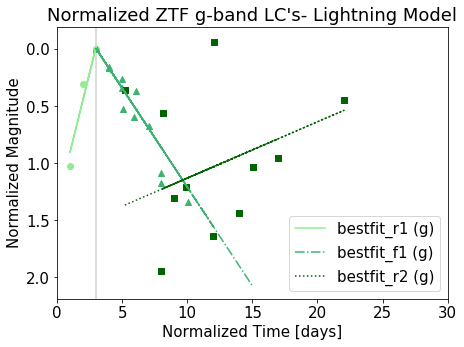

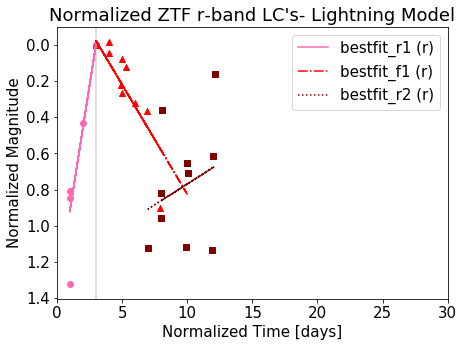

In [40]:
#combined fit g band mcmc plot

def line(x,m,b):
    return m*x +b

plt.figure(figsize=(7,5))
plt.plot(r1_g_x, line(r1_g_x, mcmc_all_g_r1[0][0], mcmc_all_g_r1[1][0]), color='lightgreen', label='bestfit_r1 (g)')
plt.plot(f1_g_x, line(f1_g_x, mcmc_all_g_f1[0][0], mcmc_all_g_f1[1][0]), color='mediumseagreen', linestyle='-.', label='bestfit_f1 (g)')
plt.plot(r2_g_x, line(r2_g_x, mcmc_all_g_r2[0][0], mcmc_all_g_r2[1][0]), color='darkgreen', linestyle='dotted', label='bestfit_r2 (g)')
plt.scatter(r1_g_x, r1_g_y, color='lightgreen', marker='o')
plt.scatter(f1_g_x, f1_g_y, color='mediumseagreen', marker='^')
plt.scatter(r2_g_x, r2_g_y, color='darkgreen', marker='s')

plt.axvline(3, linestyle='-', color='lightgray', zorder=0)
plt.title('Normalized ZTF g-band LC\'s- Lightning Model')
plt.xlabel('Normalized Time [days]')
plt.ylabel('Normalized Magnitude')
plt.legend()
plt.xlim(0, 30)
# plt.ylim(-1.5, 2.5)
plt.gca().invert_yaxis()
plt.savefig('./figures/mcmc_combined_g_r1f1r2.png')


#combined fit r band mcmc plot
plt.figure(figsize=(7,5))
plt.plot(r1_r_x, line(r1_r_x, mcmc_all_r_r1[0][0], mcmc_all_r_r1[1][0]), color='hotpink', label='bestfit_r1 (r)')
plt.plot(f1_r_x, line(f1_r_x, mcmc_all_r_f1[0][0], mcmc_all_r_f1[1][0]), color='red', linestyle='-.', label='bestfit_f1 (r)')
plt.plot(r2_r_x, line(r2_r_x, mcmc_all_r_r2[0][0], mcmc_all_r_r2[1][0]), color='maroon', linestyle='dotted', label='bestfit_r2 (r)')
plt.scatter(r1_r_x, r1_r_y, color='hotpink', marker='o')
plt.scatter(f1_r_x, f1_r_y, color='red', marker='^')
plt.scatter(r2_r_x, r2_r_y, color='maroon', marker='s')

plt.axvline(3, linestyle='-', color='lightgray', zorder=0)
plt.title('Normalized ZTF r-band LC\'s- Lightning Model')
plt.xlabel('Normalized Time [days]')
plt.ylabel('Normalized Magnitude')
plt.legend()
plt.xlim(0, 30)
# plt.ylim(-1.5, 2.5)
plt.gca().invert_yaxis()
plt.savefig('./figures/mcmc_combined_r_r1f1r2.png')

In [57]:
# TEST CELL
x,y,yerr,p0 = norm_sn21vgn_g[0][0:2], norm_sn21vgn_g[1][0:2], np.array(sn21vgn[sn21vgn['fid']==1].sigmapsf)[0:2], [-0.25, 2.0, 0.5]

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([p0[0], p0[1], np.log(p0[2])]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, _ = soln.x
log_f_ml = -2

#setting MCMC search params
pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape
print(soln.x)
print(pos)

[ -0.50761338   1.52283991 -11.5614959 ]
[[ -0.50746108   1.52281649 -11.56151931]
 [ -0.50745546   1.52291665 -11.56154284]
 [ -0.50755912   1.52279357 -11.56154247]
 [ -0.50758918   1.52264858 -11.56166839]
 [ -0.50766961   1.52273862 -11.56146447]
 [ -0.50770418   1.52269868 -11.56134933]
 [ -0.50763596   1.52284666 -11.56163837]
 [ -0.50766782   1.522851   -11.561611  ]
 [ -0.50757581   1.52277984 -11.56152507]
 [ -0.50767355   1.52302513 -11.56149725]
 [ -0.50771915   1.52292216 -11.56161798]
 [ -0.50759249   1.52264394 -11.56162871]
 [ -0.50759369   1.52291375 -11.56147876]
 [ -0.50762494   1.5228098  -11.56164375]
 [ -0.50768536   1.52279384 -11.56139018]
 [ -0.50757902   1.5226636  -11.56146349]
 [ -0.50765189   1.52277221 -11.56143473]
 [ -0.50751028   1.52293303 -11.56157982]
 [ -0.5076443    1.52287303 -11.56139834]
 [ -0.5076613    1.52282134 -11.56160653]
 [ -0.507733     1.52292116 -11.56136027]
 [ -0.50762058   1.52294026 -11.56145973]
 [ -0.50767789   1.52287605 -11.561

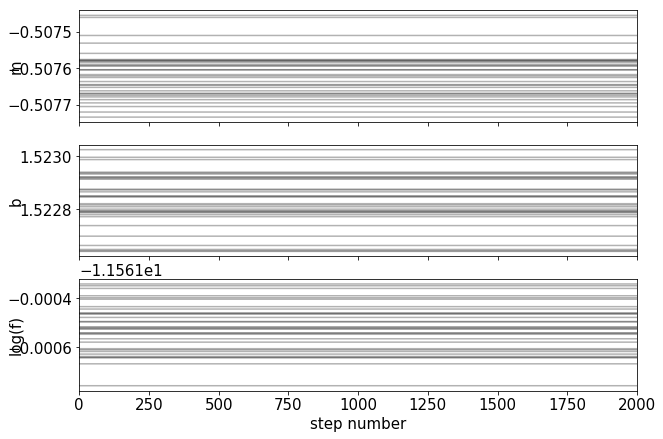

In [56]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = test.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(3):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

(4032, 3)


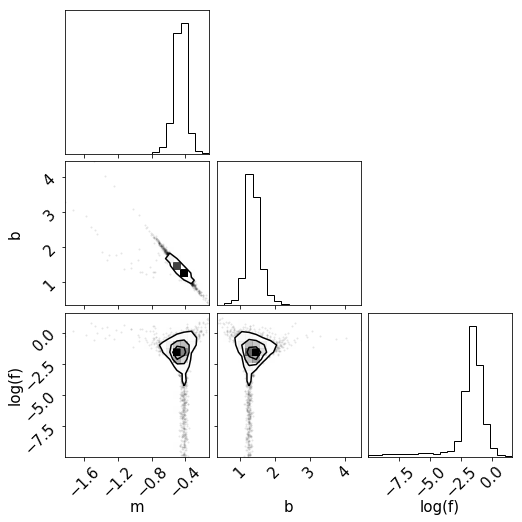

In [44]:
flat_samples = sample_r1_r.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

fig = corner.corner(
    flat_samples, labels=labels
);

In [17]:
#####################################################
#
#         all at once lightning model
#
#####################################################

In [56]:
#defining lines/liklihoods to be called in MCMC fitting
def model(theta, x):
    m1, m2, m3, b1, a1, a2, log_f = theta
    b2 = m1*a1+b1-m2*a1
    b3 = m2*a2+b2-m3*a2
    
    if x<= a1:
        model = m1*x+b1    
    elif a1< x <= a2:
        model = m2*x + (a1*(m1-m2)) + b1
    elif a2 < x:
        model = (m3*x) + (a1*(m1-m2)) + (a2*(m2-m3)) + b1
    else:
        print("smthn wrong") 
    return model

def log_likelihood(theta, x, y, yerr):
    m1, m2, m3, b1, a1, a2, log_f = theta
    model_all = np.array([model(theta, v) for v in x])
    sigma2 = yerr**2 + model_all**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model_all) ** 2 / sigma2 + np.log(sigma2))

def log_prior_combo(theta): 
    m1, m2, m3, b1, a1, a2, log_f = theta
    if -5.0<m1<=0.0 and 0.0<=m2<5.0 and -5.0<m3<=0.0 and 0.0<=b1<7.0 and 2.0<a1<4.0 and 5.0<a2<15.0 and -4.0<log_f<4.0:
        return 0.0
    return -np.inf

def log_probability_combo(theta, x, y, yerr):
    lp = log_prior_combo(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [63]:
# input: x, y, yerr, [m0,b0,logf0], rise/fall, 
# output: [[m,ml,mu],[b,bl,bu],[logf,logfl,logfu]], best_fit_model[N,2]

def mcmc_fit(x, y, yerr, p0=[-1,1,-1,3,3,7,-2]):
    #"minimizing" the log_liklihood function to find better initial guesses for MCMC fitting
    np.random.seed(42)
    nll = lambda *args: -log_likelihood(*args)
    initial = np.array([p0[0], p0[1], p0[2], p0[3], p0[4], p0[5], np.log(p0[6])]) + 0.1 * np.random.randn(7)
    soln = minimize(nll, initial, args=(x, y, yerr))
    m1_ml, m2_ml, m3_ml, b1_ml, a1_ml, a2_ml, log_f_ml  = soln.x
    log_f_ml=-2
#     new_soln = np.array([m1_ml, m2_ml, m3_ml, b1_ml, a1_ml, a2_ml, log_f_ml])

    #setting MCMC search params
#     pos = new_soln + 1e-4 * np.random.randn(32, 7)
    pos = p0 + 1e-4 * np.random.randn(128, 7)
    nwalkers, ndim = pos.shape

    #actually doing MCMC
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability_combo, args=(x, y, yerr)
    )
    sampler.run_mcmc(pos, 7500, progress=True);
    
    flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

    mcmc_results =[]
    #retrieve the 16th/50th/84th percentile for m,b,log_f and the lower/upper bounds on each
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        arr = [mcmc[1], q[0], q[1]]
        mcmc_results.append(arr)
    
    return mcmc_results, sampler

In [64]:
# x,y,yerr = norm_sn19rwd_r[0][0:7], norm_sn19rwd_r[1][0:7], np.array(sn19rwd[sn19rwd['fid']==2].sigmapsf)[0:7]
# x,y,yerr = norm_sn22jpx_r[0][0:], norm_sn22jpx_r[1][0:], np.array(sn22jpx[sn22jpx['fid']==2].sigmapsf)[0:]
x,y,yerr = norm_sn22hnt_r[0][0:8], norm_sn22hnt_r[1][0:8], np.array(sn22hnt[sn22hnt['fid']==2].sigmapsf)[0:8]
p0 = [0, 2, -2, 0, 3, 9, -2]

fit, mc = mcmc_fit(x, y, yerr, p0)

/home/aec3675/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  
100%|██████████| 7500/7500 [10:14<00:00, 12.21it/s]


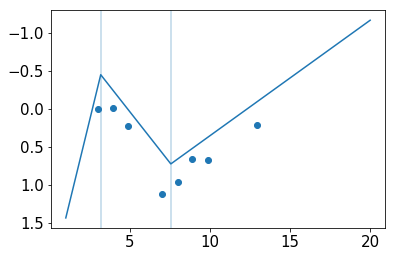

In [66]:
bestfit=[f[0] for f in fit]
bestfit

x_plt = np.arange(1,20,0.01)
plt.plot(x_plt, np.array([model(bestfit, v) for v in x_plt]))
plt.scatter(x,y)
plt.axvline(bestfit[-3],alpha=0.3)
plt.axvline(bestfit[-2],alpha=0.3)
plt.gca().invert_yaxis()

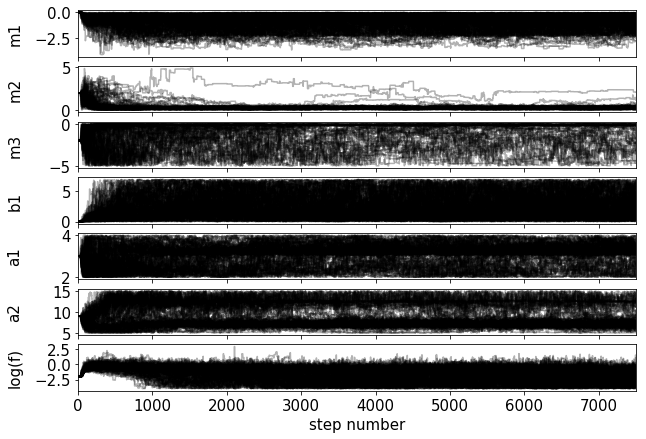

In [67]:
fig, axes = plt.subplots(7, figsize=(10, 7), sharex=True)
samples = mc.get_chain()
labels = ["m1","m2","m3","b1","a1","a2","log(f)"]
for i in range(7):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

(63104, 7)


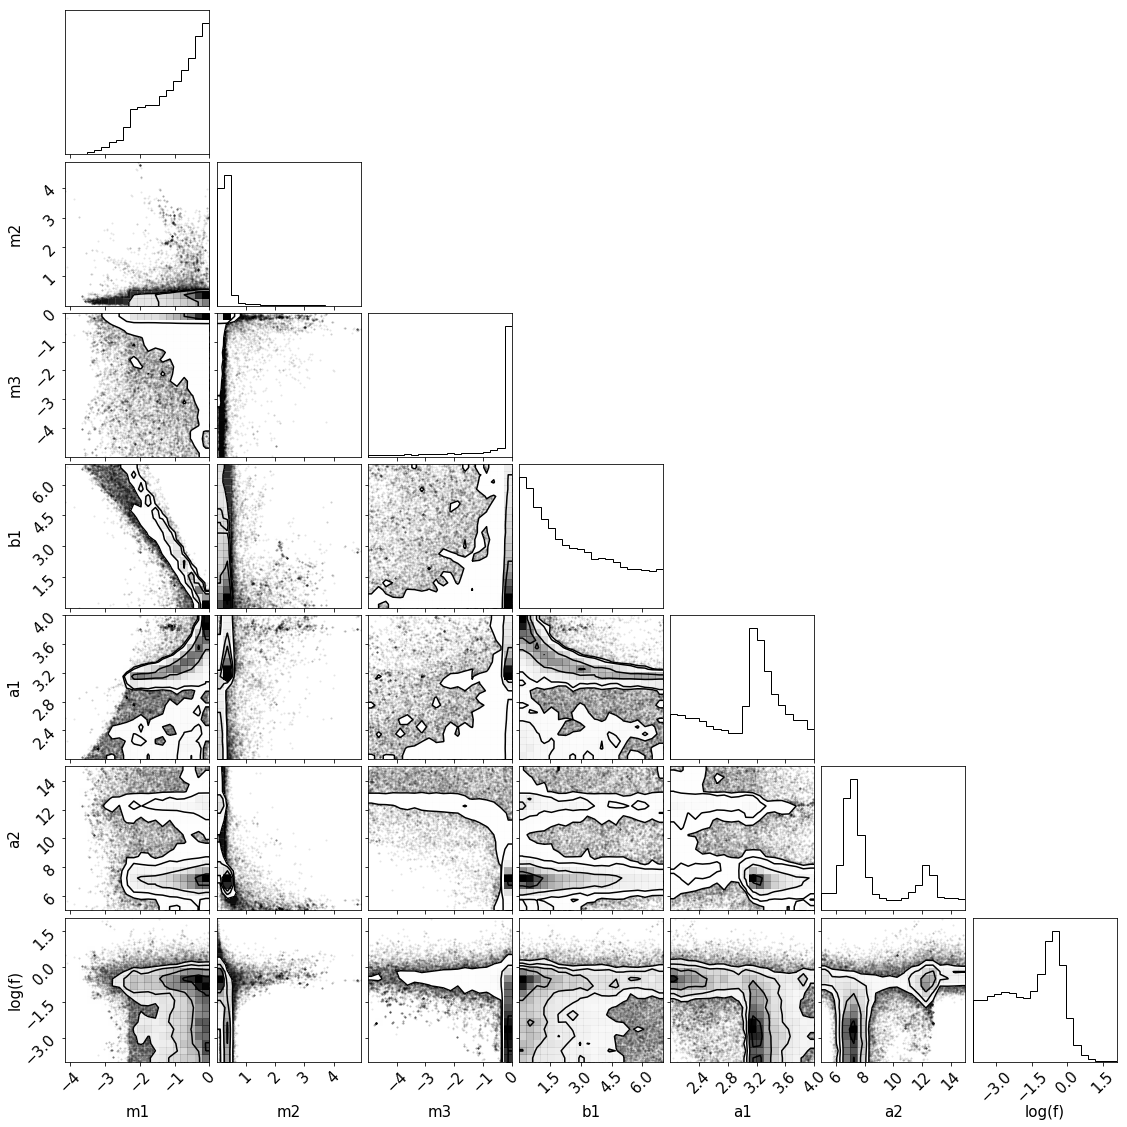

In [68]:
flat_samples = mc.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

fig = corner.corner(
    flat_samples, labels=labels
);

In [69]:
bestfit=[f[0] for f in fit]
bestfit

[-0.8633877978081783,
 0.26809996809739733,
 -0.15183417905682564,
 2.2983423052982834,
 3.179972431995746,
 7.552911021687508,
 -1.4484748472611715]